In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

with open("testSet.txt") as f:
    X = []
    y = []
    for line in f:
        line_split = line.split("\t")
        X.append(line_split[0:2])
        y.append(int(line_split[2].replace('\n','')))
    X = np.array(X,dtype='float64')
    y = np.array(y)

In [2]:
class SimpleSMO(object):
    
    def __init__(self,X,y,b,C,tolerance,MaxIter):
        
        
        self.X = X
        self.y = y
        self.b = b
        self.C = C
        self.MaxIter = MaxIter
        self.tolerance = tolerance
        self.alpha = np.zeros((self.X.shape[0],1))
        
        
    def g(self,x_i):
        #计算对输入x_i的预测值
        #此处必须reshape(-1,1)，否则就会变成100*100矩阵
        predicted_y_i = np.sum(self.alpha * self.y.reshape(-1, 1) * (np.dot(self.X,x_i.T).reshape(-1,1))) + self.b
        return predicted_y_i

    def Error(self,x_i,y_i):
        #计算预测值与输入值的误差 
        return self.g(x_i) - y_i
    
    def SelectJ(self,i):
        #简化版SMO:随机选择第二个优化变量j，并使其不等于第一个i
        j = i
        while (j==i):
            j = int(random.uniform(0,self.X.shape[0]))
        return j
    
    def Kernal(self,m,n):
        #定义核函数，用于计算Kij，本例中Kij = X[i].*X[j]
        return self.X[m].dot(self.X[n].T)
        
    
    def Optimization(self):
        iter = 0 
        #while循环用于判定变量是否继续更新，iter只有在alpha不再发生变化时才会更新
        while (iter < self.MaxIter):
            #alphaPairsChanged用于建立alpha是否改变的标志
            alphaPairsChanged = 0
            #建立for循环，for循环作为外层循环，寻找一个变量
            for i in range(self.alpha.size):
                #获得基于当前alpha下的第i个样本的误差
                E_i = self.Error(self.X[i],self.y[i])
                ##########################################
                #选择第一个变量的要求：alpha_i是否严重违反kkt条件
                ##########################################
                if (y[i] * E_i < -self.tolerance and self.alpha[i] < self.C ) \
                or (y[i] * E_i > self.tolerance and self.alpha[i] > 0 ):
                    #违反kkt条件成立，随机选择第二个优化变量aplha_j（简化版SMO算法）
                    j = self.SelectJ(i)
                    #获得基于当前alpha下的第j个样本的误差
                    E_j = self.Error(self.X[j],self.y[j])
                    #记录未更新前alpha_i,alpha_j的值（即alpha_old值）为计算new值作准备
                    alpha_i_old = self.alpha[i].copy()
                    alpha_j_old = self.alpha[j].copy()
                    #根据alpha_i_old，alpha_j_old的值获得alpha_j_new的取值范围
                    if (self.y[i] != self.y[j]):
                        L = max(0,alpha_j_old-alpha_i_old)
                        H = min(self.C,self.C + alpha_j_old - alpha_i_old)
                    else:
                        L = max(0,alpha_j_old + alpha_i_old - self.C)
                        H = min(self.C,alpha_j_old + alpha_i_old)
                    if L == H:
                        print("L=H")
                        continue
                    #计算eta
                    eta = 2 * self.Kernal(i,j)-self.Kernal(i,i)-self.Kernal(j,j)
                    if eta>= 0:
                        print("eta>=0")
                        continue
                    #根据alpha_j_old,eta，y_i,E_i,E_j更新alpha_j_new_unc未剪辑的更新值
                    alpha_j_new_unc = alpha_j_old - y[j]*(E_i-E_j)/eta
                    #获得剪辑后的更新值并保存
                    self.alpha[j] = np.clip(alpha_j_new_unc,L,H)
                    ########################################
                    #选择第二个变量的要求：alpha_j具有足够大的变化
                    ########################################
                    if abs(self.alpha[j]-alpha_j_old) < 0.00001:
                        print("j not moving enough")
                        continue
                    #根据alpha_j_old 和 更新后的self.alpha[j] 更新 self.alpha[i]
                    self.alpha[i] += self.y[i]*self.y[j]*(alpha_j_old-self.alpha[j])
                    #更新常数项b_i_new
                    b_i_new = self.b - E_i -y[i]*self.Kernal(i,i)*(self.alpha[i]-alpha_i_old) \
                    -y[j]*self.Kernal(j,i)*(self.alpha[j]-alpha_j_old)
                    #更新常数项b_j_new
                    b_j_new = self.b - E_j -y[i]*self.Kernal(i,j)*(self.alpha[i]-alpha_i_old) \
                    -y[j]*self.Kernal(j,j)*(self.alpha[j]-alpha_j_old)
                    if (self.alpha[i]>0 and self.alpha[i]<self.C):
                        self.b = b_i_new
                    elif (self.alpha[j]>0 and self.alpha[j]<self.C):
                        self.b = b_j_new                    
                    else:
                        self.b = (b_i_new + b_j_new)/2
                    #若程序无中断，alpha必然发生改变，所以标志也要变化
                    alphaPairsChanged += 1
                    print("External loop: %d; Internal loop i :%d; alphaPairsChanged :%d" % (iter,i,alphaPairsChanged))
            #只有alpha不再改变时（此时意味着很有可能是最优解），迭代次数iter更新从而验证是否为最优解
            if (alphaPairsChanged == 0):
                iter += 1
            #alpha改变时，迭代次数iter置0
            else:
                iter = 0
            print("Iteration number : %d" % iter)     
                    

In [3]:
def PlotSVM(X,y,classifier):
    X_positive = X[y==1]
    X_negative = X[y==-1]
    plt.figure(figsize = (6,4),dpi=120)
    plt.scatter(X_positive[:,0],X_positive[:,1],color = 'orange',s=30, alpha=0.7)
    plt.scatter(X_negative[:,0],X_negative[:,1],color = 'firebrick',s=30, alpha=0.7)
    W = np.sum(classifier.alpha * classifier.y.reshape(100,1) * classifier.X,axis = 0 )
    x1, x2 = np.min(X[:,0]), np.max(X[:,0])
    y1, y2 = float((-classifier.b- W[0]*x1)/W[1]), float((-classifier.b - W[0]*x2)/W[1])
    plt.plot([x1,x2],[y1,y2],color='darkmagenta')
    #绘制支持向量
    for i, alpha in enumerate(classifier.alpha):
        if abs(alpha) > 0:
            x_sv, y_sv = X[i]
            plt.scatter(x_sv, y_sv, s=150, c='none', alpha=0.7, linewidth=1.5, edgecolor='green')
    plt.title("Simple SMO")
    plt.show()

In [4]:
if __name__ == '__main__':
    SimpleSMO = SimpleSMO(X,y,0,0.6,0.001,40)
    SimpleSMO.Optimization()

L=H
L=H
L=H
L=H
L=H
External loop: 0; Internal loop i :5; alphaPairsChanged :1
External loop: 0; Internal loop i :7; alphaPairsChanged :2
L=H
L=H
L=H
L=H
External loop: 0; Internal loop i :17; alphaPairsChanged :3
j not moving enough
External loop: 0; Internal loop i :19; alphaPairsChanged :4
L=H
j not moving enough
L=H
L=H
j not moving enough
External loop: 0; Internal loop i :29; alphaPairsChanged :5
L=H
L=H
j not moving enough
External loop: 0; Internal loop i :41; alphaPairsChanged :6
External loop: 0; Internal loop i :43; alphaPairsChanged :7
L=H
External loop: 0; Internal loop i :54; alphaPairsChanged :8
L=H
External loop: 0; Internal loop i :57; alphaPairsChanged :9
j not moving enough
j not moving enough
L=H
j not moving enough
j not moving enough
L=H
j not moving enough
L=H
j not moving enough
L=H
j not moving enough
j not moving enough
L=H
j not moving enough
j not moving enough
L=H
Iteration number : 0
L=H
j not moving enough
j not moving enough
L=H
j not moving enough
j not

j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
Iteration number : 8
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
External loop: 8; Internal loop i :29; alphaPairsChanged :1
j not moving enough
j not moving enough
j not moving enough
Iteration number : 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
External loop: 0; Internal loop i :17; alphaPairsChanged :1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
Iteration number : 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
External loop: 0; Internal loop i :23; alphaPairsChanged :1
j not moving enough
j not moving enough
External loop: 0; Internal loop i :54; alphaPairsChanged :2
j not moving enough
j not moving enough
Iteration number 

j not moving enough
j not moving enough
j not moving enough
j not moving enough
Iteration number : 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
Iteration number : 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
Iteration number : 3
j not moving enough
j not moving enough
j not moving enough
External loop: 3; Internal loop i :55; alphaPairsChanged :1
Iteration number : 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
Iteration number : 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
Iteration number : 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
Iteration number : 3
j not moving enough
j not moving enough
j not moving enough
j not moving enough
Iteration number : 4
j not moving enough
j not moving enough
j not moving enough
j not moving enough
Iteration number : 5
j not moving enough
j not moving enough
j not movin

Iteration number : 7
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
Iteration number : 8
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
Iteration number : 9
j not moving enough
j not moving enough
j not moving enough
j not moving enough
External loop: 9; Internal loop i :54; alphaPairsChanged :1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
Iteration number : 0
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
Iteration number : 1
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving en

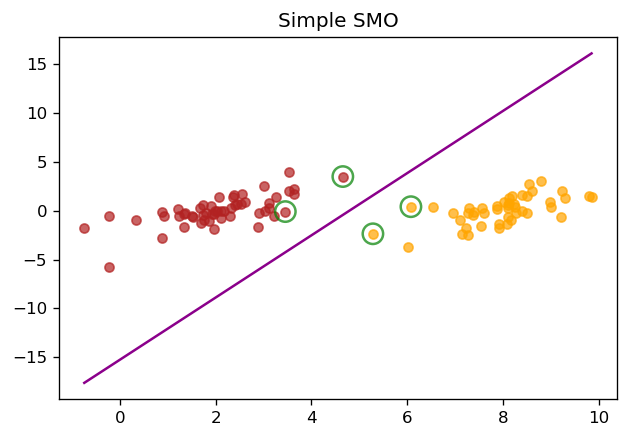

In [5]:
PlotSVM(SimpleSMO.X,SimpleSMO.y,SimpleSMO)